# load evaluation data

In [1]:
import json

def load_responses(path):
    data = []
    
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
            
    return data



In [2]:
from glob import glob
import pandas as pd


res_files = glob('data/eval2/*.json')

res_df_list = []

for f in res_files:
    model_name = f.split('/')[-1].replace(".json", "")
    correct = 0
    sra = 0
    resps = load_responses(f)
    for r in resps:
        if r['strategy'] == r['inferred_strategy']:
            correct += 1
        sra += r['sra']
    res_df_list.append({
        'acc': correct/len(resps),
        'model': model_name,
        'sra': sra/len(resps)
    })

df = pd.DataFrame(res_df_list)
df.sort_values(by=['sra'])

,acc,model,sra
1,0.10,llama2_standard,0.000634
0,0.10,llama2_c5hf,0.001060
2,0.25,llama2_c5hl,0.001068
4,0.15,llama2_c3hl,0.001421
6,0.25,llama2_c3hf,0.001606
7,0.70,llama2_c1hl,0.001922
5,0.85,llama2_c1hf,0.002122
3,0.95,llama2_ft,0.002254


In [3]:
import numpy as np

np.corrcoef(df['acc'], df['sra'])

array([[1.        , 0.90384517],
       [0.90384517, 1.        ]])

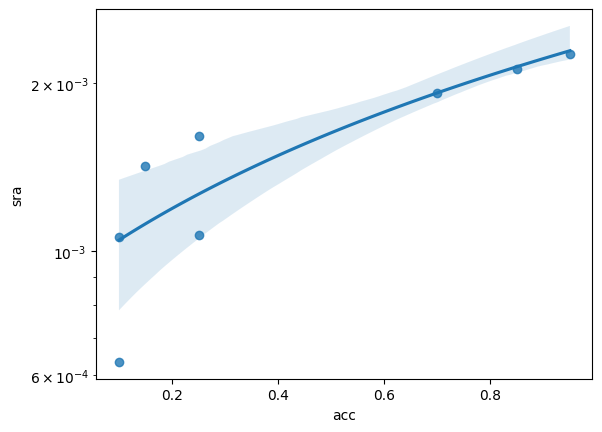

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(df, x='acc', y='sra')
plt.yscale('log')

In [5]:
import pickle

with open('../prompting/outputs/mistral7b_full/109_attentions.pkl', 'rb') as f:
    a = pickle.load(f)

In [6]:
t = a['Clarification']
len(t), t[0].shape, len(t[1])

(2, torch.Size([623]), 23)

In [7]:
t[1][2].shape

torch.Size([603])

In [21]:
from glob import glob
import pandas as pd


res_files = glob('data/eval2/*.json')

res_df_list = []

for f in res_files:
    model_name = f.split('/')[-1].replace(".json", "")
    correct = 0
    sra = 0
    resps = load_responses(f)
    print("no of instances:", len(resps))
    
    for r in resps:
        if r['strategy'] == r['inferred_strategy']:
            correct = 1
        else:
            correct = 0
        res_df_list.append({
            'correct': correct,
            'turns': len(r['messages']),
            'model': model_name,
            'sra': r['sra']
        })

df = pd.DataFrame(res_df_list)
df.sort_values(by=['sra'])

no of instances: 100
no of instances: 100
no of instances: 100
no of instances: 100
no of instances: 100
no of instances: 100
no of instances: 100
no of instances: 100


,correct,turns,model,sra
172,0,25,llama2_standard,0.000162
197,0,19,llama2_standard,0.000165
119,0,17,llama2_standard,0.000168
104,0,19,llama2_standard,0.000171
103,0,19,llama2_standard,0.000180
...,...,...,...,...
31,0,9,llama2_c5hf,0.003638
377,1,7,llama2_ft,0.003750
385,1,7,llama2_ft,0.003827
734,1,13,llama2_c1hl,0.004018


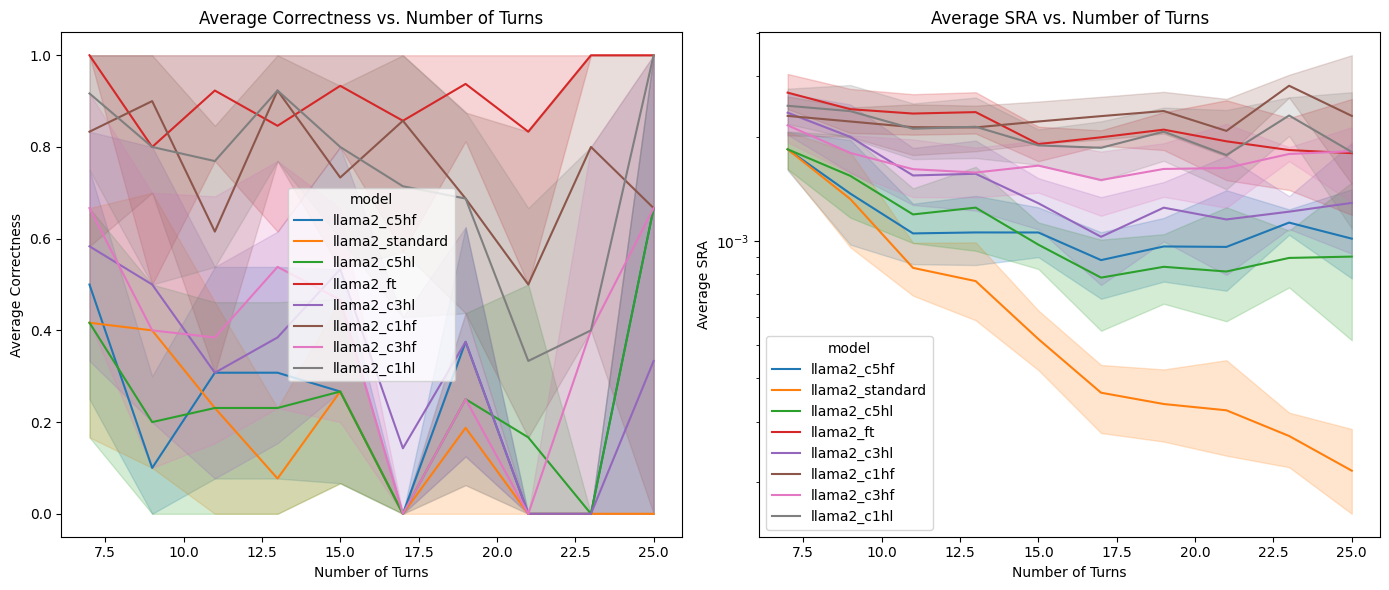

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate average correctness and SRA for each model and number of turns
avg_correctness = df.groupby(['model', 'turns'])['correct'].mean().reset_index()
avg_sra = df.groupby(['model', 'turns'])['sra'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot average correctness vs. number of turns
sns.lineplot(x='turns', y='correct', hue='model', data=df, ax=axes[0])
axes[0].set_title('Average Correctness vs. Number of Turns')
axes[0].set_ylabel('Average Correctness')
axes[0].set_xlabel('Number of Turns')

# Plot average SRA vs. number of turns
sns.lineplot(x='turns', y='sra', hue='model', data=df, ax=axes[1])
axes[1].set_title('Average SRA vs. Number of Turns')
axes[1].set_ylabel('Average SRA')
axes[1].set_xlabel('Number of Turns')
axes[1].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()
